In [1]:
from functools import lru_cache
from numba import njit 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
from scipy import integrate
from scipy.special import hermitenorm
from functools import wraps 
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

def handle_multidim(func):
    """
    Decorator to handle multi-dimensional input for Numba functions.
    The decorated function should expect 1D input.
    """
    @wraps(func)
    def wrapper(x, *args, **kwargs):
        original_shape = x.shape
        x_flat = x.ravel()
        result_flat = func(x_flat, *args, **kwargs)
        return result_flat.reshape(original_shape)
    
    return wrapper

def gaussian_pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

@lru_cache(maxsize=1000)
def compute_hermite_coefs_integration(f, order, a=-15, b=15, norm=True):
    """
    Compute Hermite coefficients using numerical integration.
    
    Parameters:
    f (callable): The function to approximate
    order (int): The number of coefficients to compute
    a, b (float): The integration limits
    norm (bool): Whether to use normalized Hermite polynomials
    
    Returns:
    np.array: The computed Hermite coefficients
    """
    def integrand(x, k):
        C = np.sqrt(np.float64(math.factorial(k))) 
        he_k = lambda x: hermitenorm(k)(x)/C
        return gaussian_pdf(x) * f(x) * he_k(x)
    
    hermite_coefs = np.zeros(order)
    
    for k in range(order):
        result, _ = integrate.quad(integrand, a, b, args=(k,))
        if norm:
            hermite_coefs[k] = result 
        else:
            hermite_coefs[k] = result
    
    return hermite_coefs




@lru_cache(maxsize=1000)
def get_activation_function(name='relu', **config):
    """
    Returns the activation function based on the provided name and optional configuration parameters.

    Parameters:
    name (str): The name of the activation function. 
                Options are 'relu', 'sigmoid', 'tanh', 'softmax', 'linear', 
                'leaky_relu', 'elu', 'selu', 'celu', 'gelu', 'swish'.
    config (dict): A dictionary of parameters for the activation function. 
                   If None, default values are used.

    Returns:
    function: A function that computes the specified activation using the provided parameters.

    Example use:
    
    f = get_activation_function('relu', {'alpha': 0.1})
    coefs = compute_hermite_coefs(f, coefs_len=20)
    f2 = hermite_expansion(coefs)
    print(coefs)
    x = np.linspace(-3, 3, 100)
    """

    @njit
    def relu(x):
        return np.maximum(0, x)
    
    @njit
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @njit
    def tanh(x):
        return np.tanh(x)
    
    @njit
    def exp(x):
        return np.exp(x)
    
    @njit
    def softmax(x):
        exps = np.exp(x)
        return exps / np.sum(exps, axis=-1, keepdims=True)
    
    @njit
    def linear(x):
        return x
    
    @njit
    def leaky_relu(x, alpha=config.get('alpha', 0.01)):
        return np.where(x > 0, x, alpha * x)
    
    @njit
    def elu(x, alpha=config.get('alpha', 1.0)):
        return np.where(x >= 0, x, alpha * (np.exp(x) - 1))
    
    @njit
    def selu(x, alpha=config.get('alpha', 1.67326), scale=config.get('scale', 1.0507)):
        return scale * np.where(x >= 0, x, alpha * (np.exp(x) - 1))
    
    @njit
    def celu(x, alpha=config.get('alpha', 1.0)):
        return np.where(x >= 0, x, alpha * (np.exp(x / alpha) - 1))
    
    @njit
    def gelu(x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
    
    @njit
    def swish(x, beta=config.get('beta', 1.0)):
        return x / (1 + np.exp(-beta * x))

    # Dictionary of activation functions
    activations = {
        'relu': relu,
        'sigmoid': sigmoid,
        'tanh': tanh,
        'exp': exp,
        'softmax': softmax,
        'linear': linear,
        'leaky_relu': leaky_relu,
        'elu': elu,
        'selu': selu,
        'celu': celu,
        'gelu': gelu,
        'swish': swish
    }
    
    return activations.get(name.lower(), None)

@lru_cache(maxsize=1000)
def factorial(k):
    assert k >= 0 and k == int(k)
    if k<=1:
        return 1
    return k * factorial(k-1)

def coefs_derivative(coefs, r):
    if r == 0:
        return coefs
    coefs = coefs.copy()
    # print(f'derivative 0 = ', ', '.join(f"c{i}={c}" for i,c in enumerate(coefs)))
    for i in range(r):
        for k in range(1,len(coefs)):
            coefs[k-1] = k * coefs[k]
        coefs[len(coefs)-1-i] = 0
        # print(f'derivative {i+1} = ', ', '.join(f"c{i}={c}" for i,c in enumerate(coefs)))
    return coefs

def coefs_to_poly(coefs):
    @njit
    def f(x):
        K = len(coefs)
        x_powers = np.zeros((K,len(x)),dtype=np.float64)
        for i in range(K):
            x_powers[i] = x**i
        return coefs @ x_powers
    return f

def hermite_poly_coefs(k):
    if k == 0:
        return np.array([1,])
    elif k == 1:
        return np.array([0,1])
    else:
        H_k_minus_1 = hermite_poly_coefs(k-1)
        H_k_minus_2 = hermite_poly_coefs(k-2)
        return np.concatenate([[0], H_k_minus_1]) - (k-1) * np.concatenate([H_k_minus_2, [0, 0]])

def hermite_poly_coefs_norm(k):
    coefs = hermite_poly_coefs(k)
    c = factorial(k)**0.5
    return coefs / c

def hermite_expansion(coefs, norm=True, return_coefs=False):
    K = len(coefs)
    cs = np.zeros(len(coefs),dtype=np.float64)
    for k,c in enumerate(coefs):
        if norm:
            cs += c * np.concatenate([hermite_poly_coefs_norm(k), np.zeros(K-1-k)])
        else:
            cs += c * np.concatenate([hermite_poly_coefs(k), np.zeros(K-1-k)])
    if return_coefs:
        return coefs_to_poly(cs), cs
    return coefs_to_poly(cs)

def hermite_poly(k,norm=True):
    coefs = np.zeros(k+1,dtype=np.float64)
    coefs[k] = 1
    return hermite_expansion(coefs, norm=norm)

@lru_cache(maxsize=1000)
def compute_hermite_coefs(f, order, norm=True, num_samples=10**7):
    X = np.random.randn(num_samples)
    hermite_coefs = np.zeros(order)
    for k in tqdm.trange(len(hermite_coefs)):
        hermite_coefs[k] = np.mean(f(X) * hermite_poly(k,norm=norm)(X))
        if not norm:
            hermite_coefs[k] /= factorial(k)
    return hermite_coefs

def kernel_map_emp(f, num_bins=100, num_samples=10**6,atol=1e-2,rtol=1e-2):
    rhos = np.linspace(-1,1,num_bins)
    vals = np.zeros(len(rhos))
    (x,y,z) = np.random.randn(3,num_samples)
    for i,rho in enumerate(rhos):
        ryz = np.sqrt(abs(rho))
        rxz = np.sign(rho) * ryz
        r = np.sqrt(1-abs(rho))
        X = rxz * z + r * y
        Y = ryz * z + r * x
        # test if rho = E[X Y], and variances are 1
        assert(np.allclose(np.mean(X * Y),rho,atol=atol,rtol=rtol))
        assert(np.allclose(np.var(X),1,atol=atol,rtol=rtol))
        assert(np.allclose(np.var(Y),1,atol=atol,rtol=rtol))
        vals[i] = np.mean(f(X) * f(Y))
    @njit
    def kernel(x):
        closest_indices = np.abs(rhos[:, np.newaxis] - x).argmin(axis=0)
        return vals[closest_indices]
    
    return kernel


# compute kernel map from Hermite coefficients
def kernel_map(coefs,r=0, norm=True):
    # cross terms dissapear, since E[He_k He_l] = 0 for k != l, leaving squared terms 
    coefs = coefs ** 2
    # if not normalized, E[He_k^2] = k!, if normalized E[He_k^2] = 1
    if not norm:
        c = 1
        for k in range(1,len(coefs)):
            c *= k
            coefs[k] = coefs[k] * c
    coefs = coefs_derivative(coefs, r)
    def kappa(x):
        return np.sum([(coefs[k]) * x**k for k in range(len(coefs))], axis=0)
    return kappa



def fixed_point_iteration(func, rho0, tol=1e-5, max_iterations=1000):
    x_values = [rho0]
    for _ in range(max_iterations):
        x_values.append(func(x_values[-1]))
        if len(x_values)>10 and abs(x_values[-1] - x_values[-2]) < tol:
            break
    return x_values


def coefs2name(poly_coefs):
    def sgn(c):
        if c==0:
            return ''
        if c>0:
            return '+'
        else:
            return '-'
    def t(i,c):
        return f'{sgn(c)}{abs(c):.1f}' + (f"x^{i}" if i>0 else "")
    act_name = (f"\\phi(x)={''.join(t(i,c) for i,c in enumerate(poly_coefs))}")
    return act_name 

def coefs2kernel_name(coefs):
    def term(c,i):
        if c==0:
            return ''
        elif i==0:
            return f'+{c:.1f}'
        else:
            return f'+{c:.1f}\\rho^{i}'
    kernel_name = (f"\\kappa(\\rho) ={''.join(term(c**2,i) for i,c in enumerate(coefs))}")
    return kernel_name


def test_hermite_coefs_integration(act_name = 'relu', order = 10):
    # input a test function name (e.g., ReLU)
    f = get_activation_function(act_name)
    
    # Compute coefficients with integration 
    coefs = compute_hermite_coefs_integration(f, order)
    
    # Compute sampling-based coefficinets
    coefs_sampling = compute_hermite_coefs(f, order)
    
    print("\nComparison with sampling-based method:")
    for i, (coef_int, coef_samp) in enumerate(zip(coefs, coefs_sampling)):
        print(f"c_{i}: Integration = {coef_int:10.7f}, Sampling = {coef_samp:10.7f}, error = {coef_int-coef_samp:10.7f}")

def test_kernel_map_from_coefs(coefs, norm, atol=1e-2, rtol=1e-2, plot=True):
    f = hermite_expansion(coefs, norm=norm)
    kernel_emp = kernel_map_emp(f)
    kernel_theory = kernel_map(coefs, norm=norm)
    x = np.linspace(-1,1,30)
    emp = kernel_emp(x)
    theory = kernel_theory(x)
    if plot:
        plt.figure()
        plt.plot(x, kernel_emp(x), label='empirical kappa(x)',marker='o')
        plt.plot(x, kernel_theory(x), label='theoretical kappa(x)')
        plt.xlabel('$\\rho$')
        plt.ylabel('$\\kappa(\\rho)$')
        plt.title(f'Kernel map in {"normalized (he)" if norm else "unnormalized (He)"} Hermite basis')
        plt.legend()
    if not np.allclose(emp, theory, atol=atol, rtol=rtol):
        print("Success: Kernel map theory and empirical values are close")
    else:
        print("Failed: Kernel map theory and empirical values are not close")


def test_kernel_map_properties_from_coefs(coefs,norm, num_samples=10**7,atol=1e-2, rtol=1e-2):
    f = hermite_expansion(coefs, norm=norm)
    kappa = kernel_map(coefs, norm=norm)
    kappa_prime = kernel_map(coefs, r=1, norm=norm)
    X = np.random.randn(num_samples)
    c0 = coefs[0]
    c1 = coefs[1]
    if norm:
        c2_sum = np.sum(coefs**2)
    else:
        c2_sum = np.sum([factorial(k) * c**2 for k,c in enumerate(coefs)])
    Ef = np.mean(f(X))
    Efx = np.mean(X * f(X))
    Ef2 = np.mean(f(X)**2)
    k0 = kappa(0)
    kprime_0 = kappa_prime(0)
    k1 = kappa(1)
    np.testing.assert_allclose(c0, Ef, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c0**2, k0, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c1, Efx, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c1**2, kprime_0, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c2_sum, Ef2, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c2_sum, k1, atol=atol,rtol=rtol)
    print(f"Success: Kernel map properties in {'normalized (he)' if norm else 'unnormalized (He)'} basis are satisfied")

# test orthogonality of polynomials 
def test_orthogonality(K=4, tol = 1e-2):
    X = np.random.randn(10**7)
    for norm in [True, False]:
        poly_name = "he" if norm else "He"
        print(f"Testing orthogonality of {'normalized' if norm else ''} Hermite polynomials ({poly_name}(x))")
        for k in range(K):
            for l in range(k,K):
                f = hermite_poly(k,norm)
                g = hermite_poly(l,norm)
                theory = float(k==l)
                if not norm:
                    theory *= factorial(k)
                emp = np.mean(f(X) * g(X))
                error = np.abs(theory - emp)
                if error > tol:
                    message = "WARNING: "
                else:
                    message = ""
                print(f"{message} E [{poly_name}_{k}(X) {poly_name}_{l}(X)], theory = {theory:5.4f}, emp =  {emp:5.4f}, error = {error:5.4f}")


        # test if we can recover the coefficients of the expansion
    
def test_recovery(coefs, tol = 5e-2):
    for norm in [True, False]:
        poly_name = "he" if norm else "He"
        print(f"Testing recovery of {'normalized' if norm else ''} Hermite coefficients ({poly_name}(x))")
        # test with He_k (not normalized)
        f = hermite_expansion(coefs,norm=norm)
        hermite_coefs = compute_hermite_coefs(f, len(coefs)+3, norm=norm)

        for k,c in enumerate(hermite_coefs):
            c_org = coefs[k] if k < len(coefs) else 0
            err = np.abs(c_org - c) 
            if err > tol:
                message = "WARNING: "
            else:
                message = ""
            print(f"{message} c_k: original = {c_org:5.4f}, recovered = {c:5.4f}, error = {err:5.4f}")

def run_tests(tol=0.02):
    test_orthogonality(K=4)
    
    # tests these properties for some random activation
    for _ in range(2):
        coefs = np.random.randn(4)
        test_recovery(coefs)
        coefs = np.random.randn(5)
        test_kernel_map_from_coefs(coefs, norm=False)
        test_kernel_map_properties_from_coefs(coefs, norm=False)
        test_kernel_map_from_coefs(coefs, norm=True)
        test_kernel_map_properties_from_coefs(coefs, norm=True)

    max_order = 25
    for act_name in ['tanh', 'relu', 'leaky_relu', 'exp', 'gelu', 'selu', 'celu', 'elu', 'sigmoid']:
        f = get_activation_function(act_name)
        coefs = compute_hermite_coefs_integration(f, order=max_order, a=-20,b=20)
        f2 = hermite_expansion(coefs)
        x = np.arange(-2,2,0.01)
        mae = np.mean(np.abs(f(x)-f2(x)))
        s = "WARNING" if mae > tol  else ""
        s += f"Hermite approx for {act_name:10} of order {max_order}, MAE = {mae:.3f}"
        print(s)


def get_activation_indicators(activation, order=25, rho0=0, tol = 1e-4):
    """
    Calculate important indicators for an activation function.
    
    Parameters:
    activation (str or np.array): Activation function name or Hermite coefficients
    order (int): Order of Hermite expansion (if activation is a string)
    rho0 (float): Initial correlation value for fixed point iteration
    
    Returns:
    dict: A dictionary containing important statistics
    """
    if isinstance(activation, str):
        f = get_activation_function(activation)
        coefs = compute_hermite_coefs_integration(f, order=order)
    else:
        coefs = activation
        activation = "custom"
    
    norm_coef = np.sqrt(np.sum(coefs**2))
    coefs_normalized = coefs / norm_coef
    
    kappa = kernel_map(coefs_normalized)
    kappa_prime = kernel_map(coefs_normalized, 1)
    
    rhos = fixed_point_iteration(kappa, rho0=rho0)
    rho_star = rhos[-1]
    
    k0 = kappa(0)
    k_prime_star = kappa_prime(rho_star)
    k_prime_1 = kappa_prime(1)
    k_prime_0 = kappa_prime(0)

    
    # Determine the convergence case
    if abs(k0) < tol:
        case = '1'
        alpha = 1/(2-k_prime_0)
        bound = r'\frac{|\rho|}{(1 - |\rho_0| + |\rho_0| A^\ell}'
    else:
        if k_prime_1 < 1-tol:
            case = '2'
            alpha = k_prime_1
            bound = r'|\rho_0-R| A^\ell'
            bound.replace
        elif abs(k_prime_1-1) < tol:
            case = '3'
            alpha = k0+k_prime_0
            bound = r'\frac{|\rho_0-R|}{\ell (1-A) |\rho_0-R| + 1}'
        else:
            case = '4'
            alpha1 = (1-rho_star)/(2-k_prime_star)
            alpha2 = k_prime_star
            alpha3 = 1-k0
            alpha = max([alpha1,alpha2,alpha3])
            bound = r'\frac{|\rho_0-R|A^\ell}{1 - |\rho_0| + |\rho_0|A^\ell}'
    # bound = bound.replace('A', f'{alpha:.2f}')
    # bound = bound.replace('R', f'{rho_star:.2f}')
    bound = bound.replace('A', r'\alpha')
    bound = bound.replace('R', r'\rho_\star')
    
    return {
        r"$\phi$": f'{activation}',
        r"$C=\E\phi(X)^2$": norm_coef,
        r"$\alpha$": alpha,
        r"$\rho_\star$": rho_star,
        r"$\kappa(\rho_\star)$": kappa(rho_star),
        r"$\kappa(0)$": kappa(0),
        r"$\kappa'(0)$": k_prime_0,
        r"$\kappa'(1)$": k_prime_1,
        r"$\kappa'(\rho*)$": k_prime_star,
        r"\text{Case}": case,
        "hermite_coefs": coefs,
    }



def calculate_convergence_params(kappa, kappa_prime, rho0, tol=1e-4, layers=30):
    rhos = fixed_point_iteration(kappa, rho0=rho0)
    rho_star = rhos[-1]
    rhos = rhos[:layers]
    ls = np.arange(len(rhos))

    k0 = kappa(0)
    k_prime_star = kappa_prime(rho_star)
    k_prime_1 = kappa_prime(1)
    k_prime_0 = kappa_prime(0)


    if abs(k0) < tol:
        case = 'case 1'
        x0 = abs(rho0-rho_star)
        alpha = 1/(2-k_prime_0)
        bound = x0 * alpha**ls / (1-x0 + x0 * alpha**ls)
    else:
        if k_prime_1 < 1-tol:
            case = 'case 2'
            alpha = k_prime_1
            bound = abs(rho0-rho_star) * alpha**ls
        elif abs(k_prime_1-1) < tol:
            case = 'case 3'
            alpha = k0+k_prime_0
            bound = abs(rho0-rho_star) / (ls * (1-alpha) * abs(rho0-rho_star) + 1)
        else:
            case = 'case 4'
            alpha1 = (1-rho_star)/(2-k_prime_star)
            alpha2 = k_prime_star
            alpha3 = 1-k0
            alpha = max([alpha1,alpha2,alpha3])
            bound = (abs(rho0-rho_star) * alpha**ls) / (1 - abs(rho0) + abs(rho0) * alpha**ls)
    return rhos, rho_star, bound, case


def plot_kernel_convergence(ax, kappa, kappa_prime, rho0, tol=1e-4, layers=30, plot_type='bound'):
    rhos, rho_star, bound, case = calculate_convergence_params(kappa, kappa_prime, rho0, tol, layers)
    
    # plt.figure(figsize=(10, 6))
    
    if plot_type == 'convergence':
        ax.plot(rhos, marker='.', label='empirical $\\rho_\\ell$')
        sign, B = (1, 'upper') if rhos[0] > rho_star else (-1, 'lower')
        ax.plot(rho_star + sign * bound, '-', marker='.', color='red', label=f'{B} bound ({case})')
        ax.axhline(rho_star, linestyle='--', color='black', label='$\\rho^*$')
        ax.set_ylim(-1,1.1)
        ax.set_ylabel('$\\rho$')
        ax.set_title('Convergence towards $\\rho^*$')
    elif plot_type == 'bound':
        ax.plot(np.abs(rhos-rho_star), marker='.',label='empirical $|\\rho_\\ell - \\rho^*|$')
        ax.plot(bound, '--', color='red', marker='.',label=f'theory ({case})')
        ax.set_ylabel('$|\\rho_\\ell-\\rho^*|$')
        # ax.set_ylim(-0.1,1.1*max(np.abs(rhos-rho_star)))
        ax.set_yscale('log')
        ax.set_title('Distance towards $\\rho^*$')
    
    ax.set_xlabel('$\\ell$')
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

def act_conf2name(act_conf, tol=1e-2):
    if isinstance(act_conf, str):
        # Case 1: Activation name with default parameters
        name = act_conf
    elif isinstance(act_conf, np.ndarray):
        # Case 2: Hermite coefficients directly provided
        coefs = act_conf
        coefs = [f"{' +' if c > 0 else ' -'}{abs(c):.2f} \\he_{k}" for k,c in enumerate(coefs) if abs(c)>tol]
        name = "".join(coefs)
    elif isinstance(act_conf, dict):
        # Case 3: Config dictionary with custom parameters
        act_name = act_conf.get('name')
        del act_conf['name']
        args = [f"{k}={v}" for k,v in act_conf.items()]
        args = ','.join(args)
        name = f'{act_name}({args})'
    return name


def plot_activation_analysis(axes, f_norm, coefs, kappa, kappa_prime, rho0, act_conf,tol=1e-2):
    plot_activation(axes[0], f_norm, act_conf=act_conf, a=-3, b=3, )
    plot_fixed_point_iteration(axes[1], kappa, rho0, -1, 1, kernel_name='\\kappa(\\rho)', )
    plot_kernel_convergence(axes[2], kappa, kappa_prime, rho0, tol=tol, layers=100, plot_type='convergence',)
    plot_kernel_convergence(axes[3], kappa, kappa_prime, rho0, tol=tol, layers=100, plot_type='bound',)

def plot_activation(ax, f, act_conf, a=-3, b=3,):
    x = np.linspace(a, b, 1000)
    ax.plot(x, f(x), label='\phi', linewidth=2)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(f'$\\phi = {act_conf2name(act_conf)}$', fontsize=14)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

def plot_fixed_point_iteration(ax, func, rho0, a=0, b=1, tol=1e-5, max_iterations=1000, kernel_name='\\kappa(\\rho)'):
    x_values = fixed_point_iteration(func, rho0, tol=tol, max_iterations=max_iterations)
    x = np.linspace(a, b, 1000)
    
    ax.plot(x, func(x), label=f'${kernel_name}$', color='blue', linewidth=2)
    ax.plot(x, x, label='identity', color='black', linestyle='--', linewidth=1.5)
    
    for i in range(1, len(x_values)):
        ax.plot([x_values[i-1], x_values[i-1]], [x_values[i-1], x_values[i]], 'r', linewidth=0.5)
        ax.plot([x_values[i-1], x_values[i]], [x_values[i], x_values[i]], 'r', linewidth=0.5)
        
    ax.scatter(x_values[-1], x_values[-1], marker='*', color='red', s=100, zorder=5, label=f'Fixed $\\rho^*={x_values[-1]:.2f}$')
    ax.scatter(x_values[0], func(x_values[0]), marker='o', color='red', s=50, zorder=5, label=f'Initial $\\rho_0={rho0:.2f}$')

    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    
    ax.set_title(f'$\\kappa(\\rho)$', fontsize=14)
    ax.set_xlabel('pre-act $\\rho_\\ell$', fontsize=12)
    ax.set_ylabel('post-act $\\rho_{\\ell+1}=\\kappa(\\rho)$', fontsize=12)
    ax.legend(fontsize=8, loc='best')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

def create_subplot_grid(fig, rows, cols):
    gs = GridSpec(rows, cols, figure=fig, hspace=0.4, wspace=0.3)
    return np.array([[fig.add_subplot(gs[i, j]) for j in range(cols)] for i in range(rows)])

def generate_latex_table(activation_names):
    # Header for the LaTeX table
    latex_table = None

    # Generate rows for each activation function
    for act_conf in activation_names:
        stats = get_activation_indicators(act_conf,order=25)
        stats = {k:v for k,v in stats.items() if  isinstance(v,str) or isinstance(v,float)}
        if latex_table is None:
            latex_table = r"""
\begin{table}[h]
\centering
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{|"""  + "c|"*len(stats) + r""" }
\toprule
            """
            # latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|" + "c|"*len(stats) + "}\n\\hline\n"
            latex_table += ' & '.join(stats.keys()) + " \\\\ \\midrule \n"
        row = ""
        for k,v in stats.items():
            row += (f"{v:.2f}" if isinstance(v,float) else v) + " &"
        row = row[:-2] + "\\\\ \n"
        latex_table += row

    # Close the LaTeX table
    latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{Activation Function Statistics}\n\\label{tab:activation_stats}\n\\end{table}"

    return latex_table
    
def prepare_activation_data(act_conf, order=25):
    """
    Prepares activation data by handling three types of input:
    1) Activation function name with default values.
    2) Hermite coefficients directly.
    3) A config dictionary specifying the activation name and required parameters.

    Parameters:
    input_data (str, np.array, or dict): 
        - If str: the name of the activation function.
        - If np.array: Hermite coefficients.
        - If dict: a configuration dictionary with the activation function name and its parameters.
    order (int): The order of Hermite expansion (default 25).
    
    Returns:
    tuple: A tuple containing normalized activation function, Hermite coefficients, kernel maps, 
           and other relevant statistics.
    """
    if isinstance(act_conf, str):
        # Case 1: Activation name with default parameters
        f = get_activation_function(name=act_conf)
        coefs = compute_hermite_coefs_integration(f,order=order) 
    elif isinstance(act_conf, np.ndarray):
        # Case 2: Hermite coefficients directly provided
        coefs = act_conf
    elif isinstance(act_conf, dict):
        # Case 3: Config dictionary with custom parameters
        f = get_activation_function(**act_conf)
        coefs = compute_hermite_coefs_integration(f,order=order) 
    else:
        raise ValueError("Unsupported input format. Must be str, np.array, or dict.")
    
    # normalize 
    norm_coef = np.sqrt(np.sum(coefs**2))
    coefs /= norm_coef
    f_norm = lambda x: f(x) / norm_coef
    
    # Generate kernel maps
    kappa = kernel_map(coefs)
    kappa_prime = kernel_map(coefs, 1)
    
    return f_norm, coefs, kappa, kappa_prime, norm_coef
    
def plot_activation_comparisons(act_init, save_path, order=20):
    N = len(act_init)
    fig = plt.figure(figsize=(4*4+1, 4*N+1))  # Increased figure size to accommodate labels
    axes = create_subplot_grid(fig, N, 4)

    for n, (rho0, act_conf) in enumerate(act_init):
        f_norm, coefs, kappa, kappa_prime, norm_coef = prepare_activation_data(act_conf, order=order)
        # print(f"act = {act_conf2name(act_conf)}")
        plot_activation_analysis(axes[n][:], f_norm, coefs, kappa, kappa_prime, rho0, act_conf)
        

    # Adjust the layout
    plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300, pad_inches=0.5)
    plt.show()


def plot_hermite_approximation_analysis(act_name, max_order=30):
    f = get_activation_function(act_name)
    coefs = compute_hermite_coefs_integration(f, order=max_order)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # fig.suptitle(f'Hermite Approximation Analysis for {act_name.capitalize()}', fontsize=20)
    
    # Plot 1: Original function vs Approximation
    x = np.linspace(-2, 2, 1000)
    f2 = hermite_expansion(coefs)
    axs[0].plot(x, f(x), label=act_name, linewidth=2)
    axs[0].plot(x, f2(x), label=f'{act_name} approx. (order={max_order}).', linewidth=2, linestyle='--')
    axs[0].set_title('Original vs Approximation')
    axs[0].legend()
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].grid(True, alpha=0.3)
    
    # Plot 2: Hermite Coefficients
    axs[1].bar(range(len(coefs)), coefs, alpha=0.7)
    axs[1].set_title('Hermite Coefficients')
    axs[1].set_xlabel('Coefficient Index')
    axs[1].set_ylabel('Coefficient Value')
    axs[1].grid(True, alpha=0.3)
    axs[1].set_yscale('symlog', linthresh=.01)
    
    # Plot 3: Mean Absolute Error vs Number of Coefficients
    mae_values = []
    for i in range(1, max_order + 1):
        f_approx = hermite_expansion(coefs[:i])
        mae = np.mean(np.abs(f(x)- f_approx(x)))
        mae_values.append(mae)
    
    axs[2].plot(range(1, max_order + 1), mae_values, marker='o')
    axs[2].set_title('Mean Absolute Error vs Number of Coefficients')
    axs[2].set_xlabel('Number of Coefficients')
    axs[2].set_ylabel('Mean Absolute Error')
    axs[2].set_yscale('log')
    axs[2].grid(True, alpha=0.3)
    
    # Remove the fourth plot
    # fig.delaxes(axs[1, 1])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    
## you can uncomment lines bellow to test if the basic properties hold 
# run_tests()

<>:591: SyntaxWarning: invalid escape sequence '\p'
<>:591: SyntaxWarning: invalid escape sequence '\p'
/var/folders/zn/c_3kf_gx42n9mqlw1f1qh4rc0000gn/T/ipykernel_42884/996535034.py:591: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x, f(x), label='\phi', linewidth=2)


51.7 μs ± 1.64 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
49.9 μs ± 1.82 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Basic properties of Hermite polynomials 

We use the recursive Hermite polynomial defintion 
$$
He_0(x)=1, \qquad He_1(x)=x, \qquad He_k(x) = x He_{k-1}(x) - (k-1) He_{k-2}(x)
$$
and normalized Hermite 
$$
he_k(x) = \frac{1}{\sqrt{k!}}He_k(x) 
$$
**Orthogonality of Hermite polynomials:**
$$
E_{X\sim N(0,1)} [He_k(X) He_l(x)]= k! \delta_{kl},\qquad 
E_{X\sim N(0,1)} [he_k(X) he_l(x)]= \delta_{kl}
$$
where $\delta$ is Dirac delta, and also its normalized version. 

*Expansion in Hermite basis:* Based on orthognoality, we can expand in the normalized basis as 
$$
f(x) = \sum_{k=0}^\infty c_k he_k(x), \qquad c_k = E_{X\sim N(0,1)}f(X)he_k(X)
$$
and not normalized basis as 
$$
f(x) = \sum_{k=0}^\infty c_k He_k(x), \qquad c_k = \frac{1}{k!} E_{X\sim N(0,1)}f(X)He_k(X) 
$$



**Kernel map**
If $X,Y$ are standard Gaussian with covariance $\rho,$ we define the kernel map $f$, as 
$$
\kappa_f(\rho) := E_{X,Y} f(X)f(Y) X,Y\sim N(0,1), E XY=\rho
$$
- Thus, in the normalized Hermite basis we have
$$
\kappa_f(\rho)=\sum_{k=0}^\infty c_k^2 \rho^k, \qquad f(x)=\sum_{k=0}^\infty c_k he_k(x), 
$$
Basic properties of kernel map:
- in the normalized basis we have
$$
E f(X) = c_0 = \sqrt{\kappa(0)}, \qquad E f(X)^2 = \sum_{k=0}^\infty c_k^2 = \kappa(1),  
$$



# Hermite approximation of activation function 

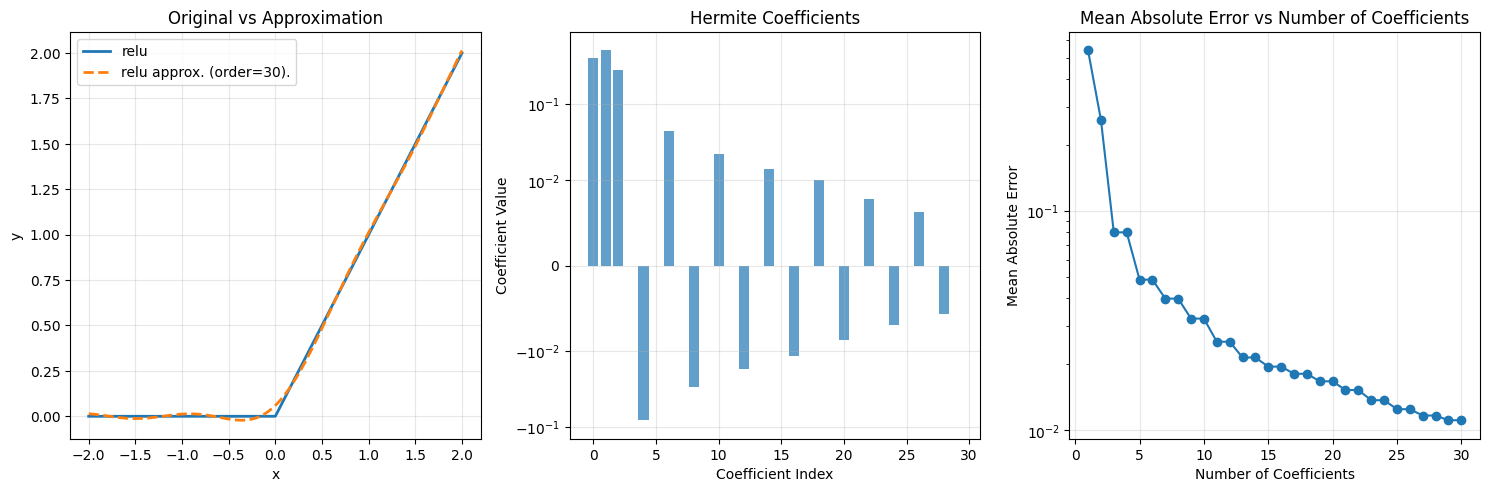

In [3]:


# Example usage
act_name = 'relu'
plot_hermite_approximation_analysis(act_name,)


# Supplementary figures and tables 

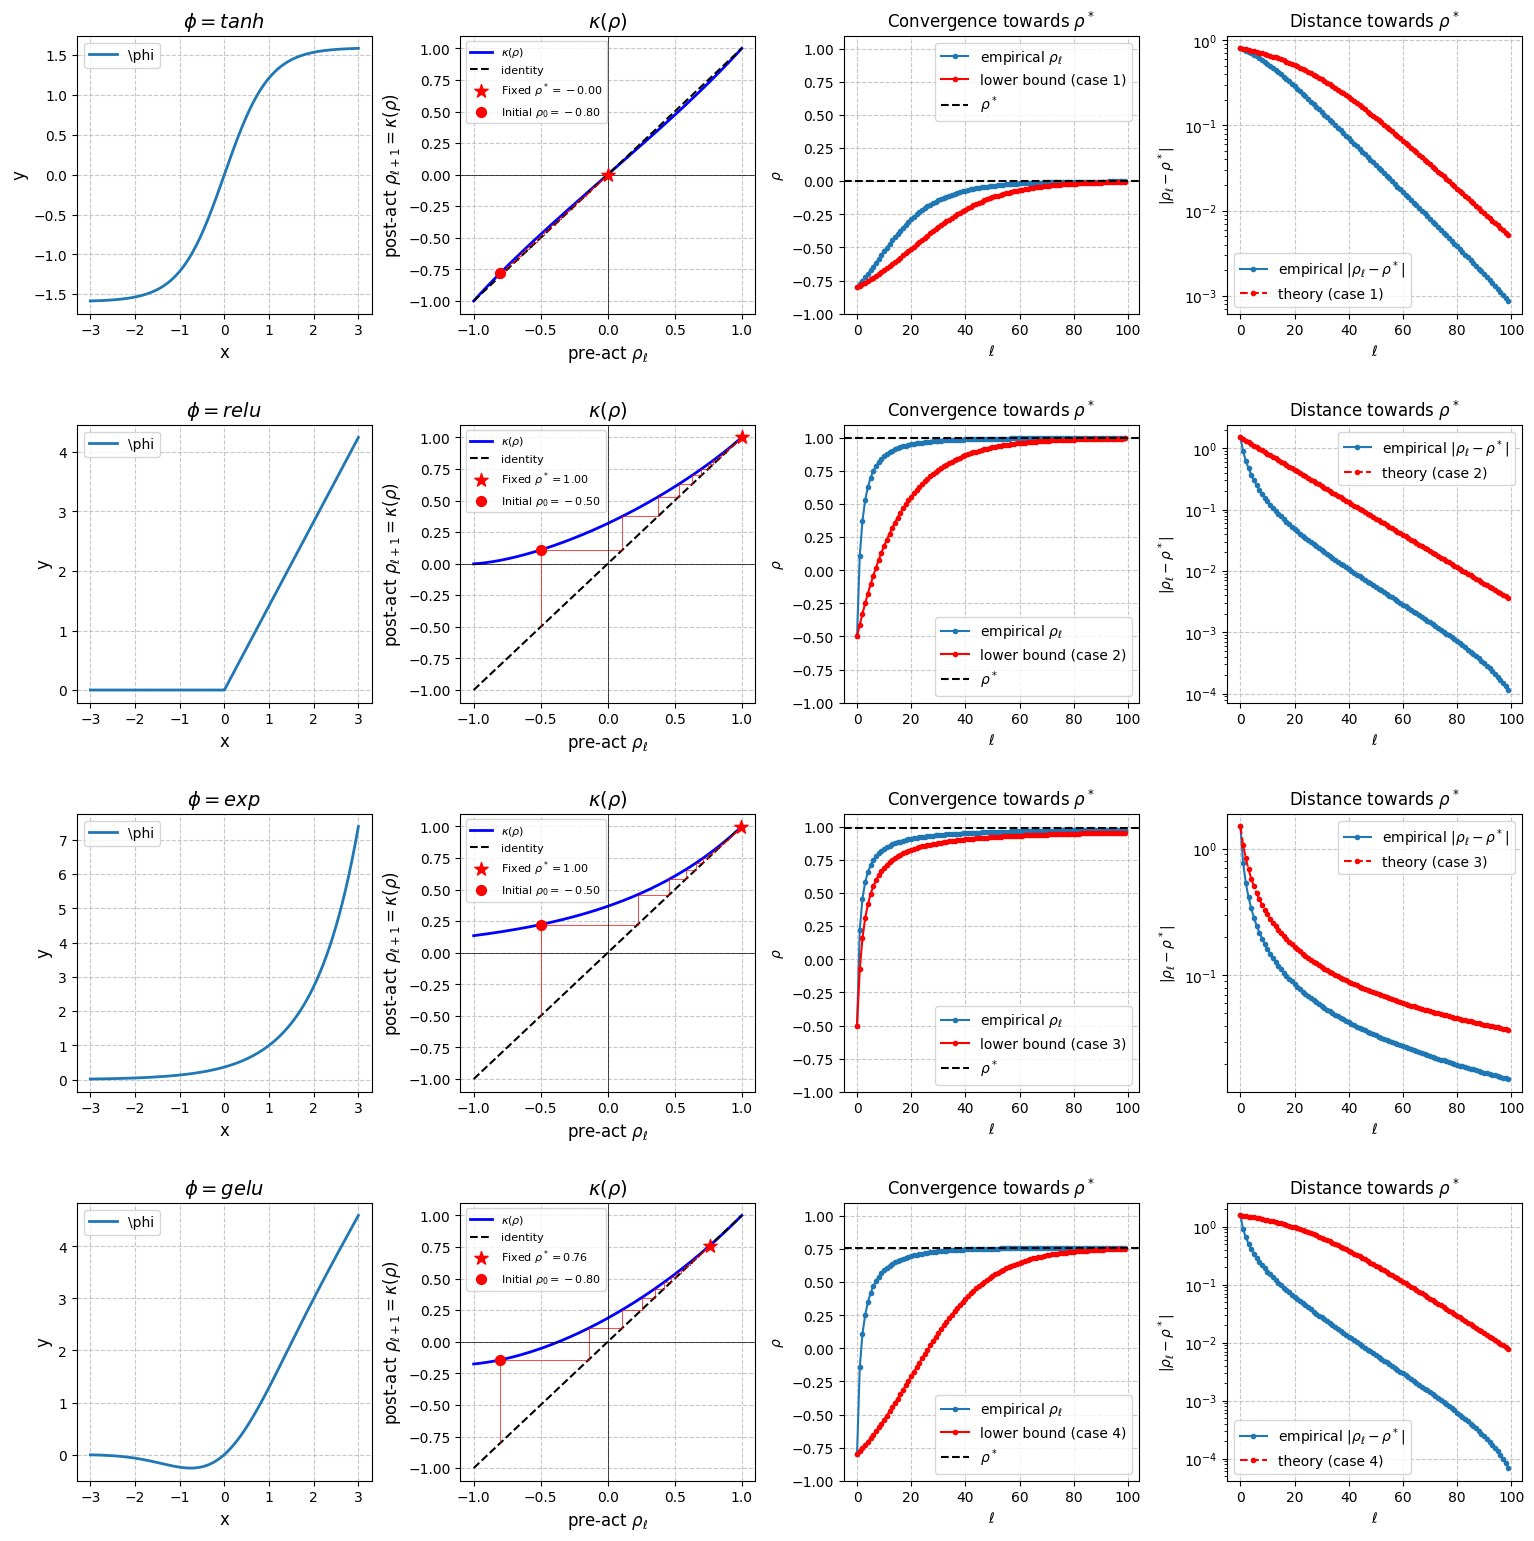

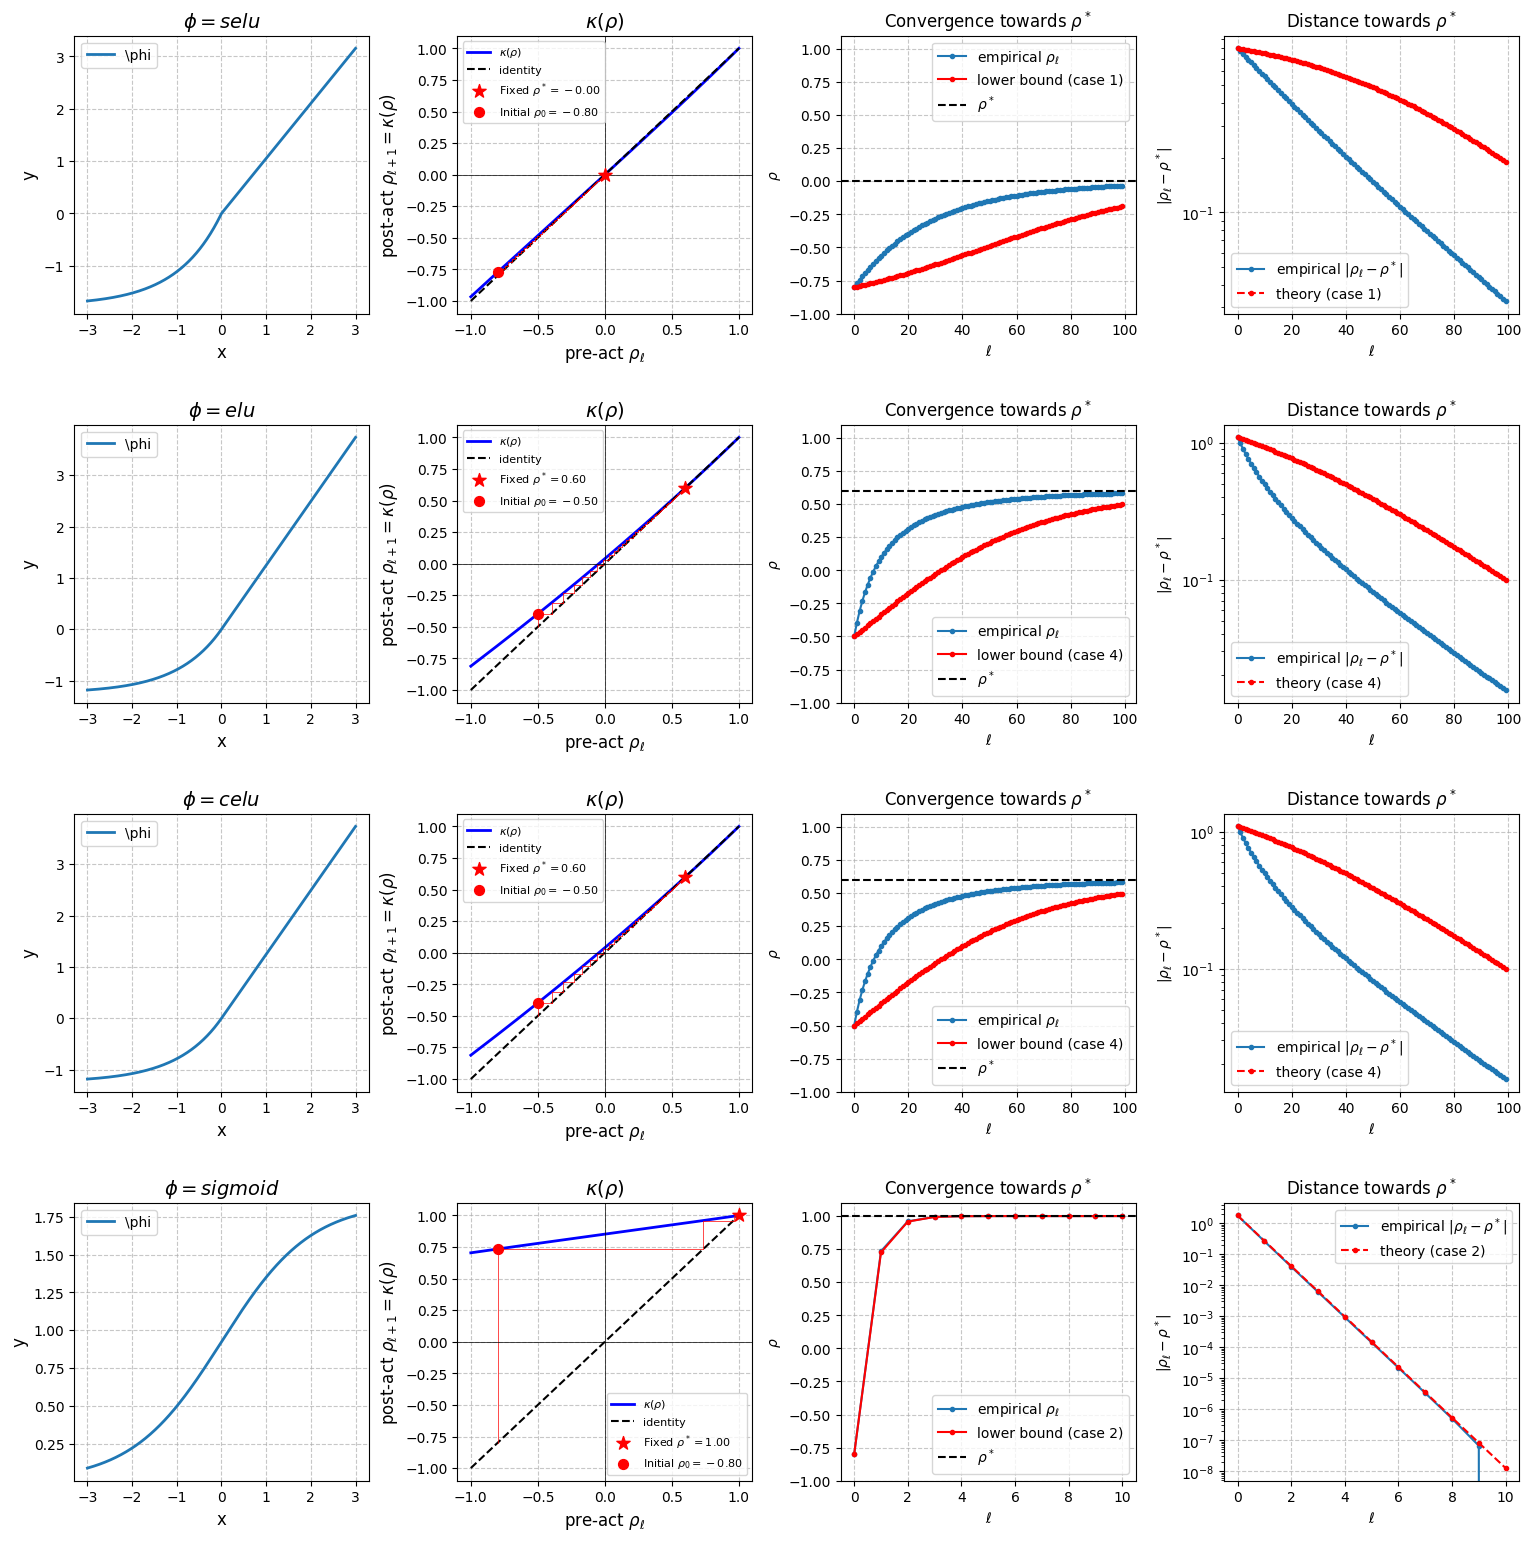


\begin{table}[h]
\centering
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c| }
\toprule
            $\phi$ & $C=\E\phi(X)^2$ & $\alpha$ & $\rho_\star$ & $\kappa(\rho_\star)$ & $\kappa(0)$ & $\kappa'(0)$ & $\kappa'(1)$ & $\kappa'(\rho*)$ & \text{Case} \\ \midrule 
tanh &0.63 &0.93 &0.00 &0.00 &0.00 &0.93 &1.18 &0.93 &1\\ 
relu &0.71 &0.95 &1.00 &1.00 &0.32 &0.50 &0.95 &0.95 &2\\ 
leaky_relu &0.71 &0.95 &1.00 &1.00 &0.31 &0.51 &0.95 &0.95 &2\\ 
exp &2.72 &0.74 &1.00 &1.00 &0.37 &0.37 &1.00 &1.00 &3\\ 
gelu &0.65 &0.93 &0.76 &0.76 &0.19 &0.59 &1.07 &0.93 &4\\ 
selu &1.00 &0.97 &0.00 &0.00 &0.00 &0.97 &1.06 &0.97 &1\\ 
celu &0.80 &0.97 &0.60 &0.60 &0.04 &0.90 &1.04 &0.97 &4\\ 
elu &0.80 &0.97 &0.60 &0.60 &0.04 &0.90 &1.04 &0.97 &4\\ 
sigmoid &0.54 &0.15 &1.00 &1.00 &0.85 &0.15 &0.15 &0.15 &2\\ 
\bottomrule
\end{tabular}
\caption{Activation Function Statistics}
\label{tab:activation_stats}
\end{table}


In [4]:



act_init = [(-.8, 'tanh'), (-.5, 'relu'), (-.5, 'exp'), (-.8, 'gelu')]
plot_activation_comparisons(act_init, save_path='images/kernel_convergence.pdf')

act_init = [(-.8, 'selu'), (-.5, 'elu'), (-.5, 'celu'), (-.8, 'sigmoid')]
plot_activation_comparisons(act_init, save_path='images/kernel_convergence_2.pdf')


activation_names = ['tanh', 'relu', 'leaky_relu', 'exp', 'gelu', 'selu', 'celu', 'elu', 'sigmoid']
latex_table_string = generate_latex_table(activation_names)
print(latex_table_string)



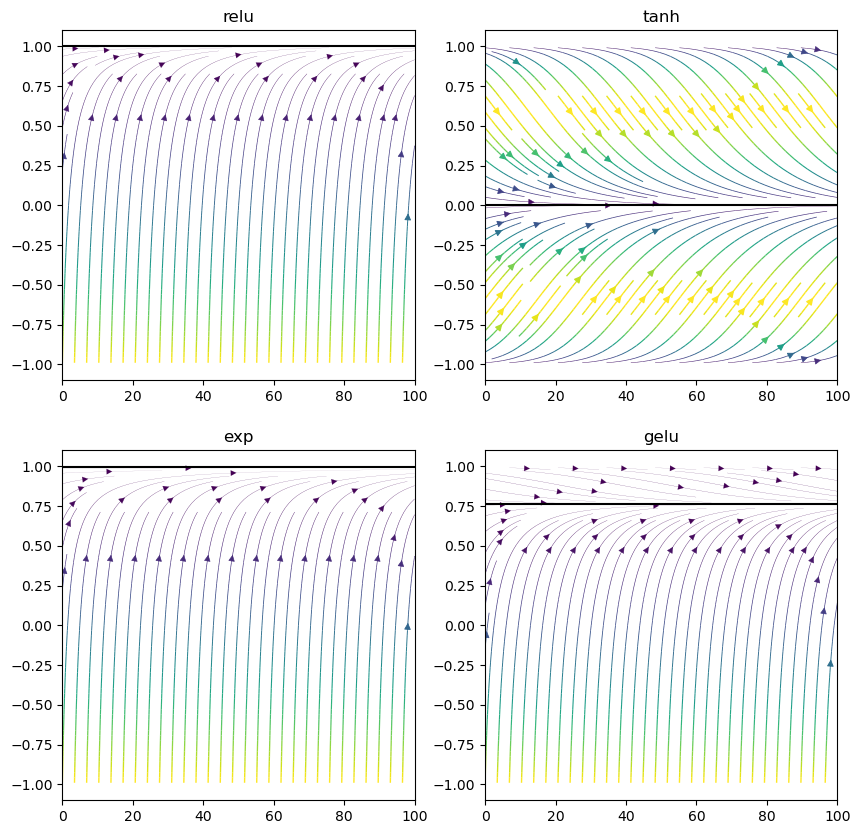

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def get_fp_kappa(activation, order=25, rho0=0, tol = 1e-4):
    if isinstance(activation, str):
        f = get_activation_function(activation)
        coefs = compute_hermite_coefs_integration(f, order=order)
    else:
        coefs = activation
        activation = "custom"
    
    norm_coef = np.sqrt(np.sum(coefs**2))
    coefs_normalized = coefs / norm_coef
    
    kappa = kernel_map(coefs_normalized)
    kappa_prime = kernel_map(coefs_normalized, 1)
    
    rhos = fixed_point_iteration(kappa, rho0=rho0)
    rho_star = rhos[-1]


    return rho_star, kappa, kappa_prime


def stream_plot(ax, f, L, a=-1, b=1, rho_star=0):
    # Create a grid for the stream plot
    X, T = np.mgrid[a:b:200j, 0:L:200j]  # X corresponds to x(t), T is time
    
    # Calculate the velocity field: dx/dt
    U = f(X)  # U is the time derivative (velocity in the x direction)
    V = np.ones_like(T)  # V is 1 since dt/dt is always 1 (constant velocity in the time direction)
    speed = np.sqrt(U**2 + V**2)  # Compute speed (magnitude of velocity vector)
    
    # Plot the streamlines
    lw = 1 * (abs(U) / U.max())**0.4  # Linewidth proportional to speed
    # X = X - rho_star
    strm = ax.streamplot(T, X, V, U, 
                         color=abs(U), 
                         linewidth=lw,
                         density=[1,2], cmap=plt.cm.viridis)
    ax.axhline(y=rho_star, linestyle='-', color='k', label='$\\rho_\\star$')
    # ax.set_yscale('symlog', linthresh=0.1)
    # ax.set_yscale('log')
    # ax.colorbar(strm.lines)
    ax.set_ylim(-1.1,1.1)

def get_ode(act_name):
    act = get_activation_function(act_name)
    coefs = compute_hermite_coefs_integration(act,order=25)
    coefs = coefs**2 / np.sum(coefs**2)
    coefs[1] -= 1
    f = coefs_to_poly(coefs)
    
    return f
    

# Define the ODE: dx/dt = f(x)
fig, axes = plt.subplots(2,2, figsize=(10,10))
for i, act in enumerate(['relu', 'tanh', 'exp', 'gelu',]):
    ax = axes.flatten()[i]
    f = handle_multidim(get_ode(act))
    rho_star, _, _, = get_fp_kappa(act)
    stream_plot(ax, f, L=100, a=-0.99, b=.99, rho_star=rho_star)
    ax.set_title(f'{act}')

# plt.show()


In [7]:
get_activation_indicators('relu')

{'$\\phi$': 'relu',
 '$C=\\E\\phi(X)^2$': 0.7068570612162182,
 '$\\alpha$': 0.9486584736120656,
 '$\\rho_\\star$': 0.9998192245266329,
 '$\\kappa(\\rho_\\star)$': 0.9998285259404297,
 '$\\kappa(0)$': 0.3185348323026026,
 "$\\kappa'(0)$": 0.5003533445371564,
 "$\\kappa'(1)$": 0.9486584736120656,
 "$\\kappa'(\\rho*)$": 0.9484358702157956,
 '\\text{Case}': '2',
 'hermite_coefs': array([ 3.98942280e-01,  5.00000000e-01,  2.82094792e-01, -8.67361738e-18,
        -8.14337520e-02,  0.00000000e+00,  4.46031029e-02,  1.38777878e-17,
        -2.98017017e-02, -2.08166817e-17,  2.19896263e-02,  1.38777878e-17,
        -1.72255617e-02, -1.38777878e-17,  1.40452794e-02,  1.04083409e-17,
        -1.17860455e-02,  3.29597460e-17,  1.01064507e-02, -3.60226172e-17,
        -8.81364967e-03, -4.53264271e-17,  7.79091376e-03, -2.61021673e-17,
        -6.96366953e-03])}

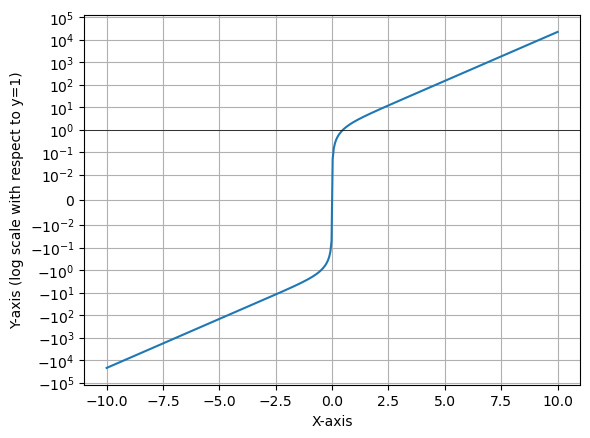

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data for demonstration
x = np.linspace(-10, 10, 400)
y = np.exp(x) - np.exp(-x)  # Just an example to have data around y = 1

# Plotting with symlog scale, centered around y=1
fig, ax = plt.subplots()

ax.plot(x, y)

# Set the y scale to symlog, with reference point at y = 1
ax.set_yscale('symlog', linthresh=0.01)

# Customize the grid and labels
ax.grid(True, which='both')
ax.axhline(y=1, color='black', lw=0.5)  # reference line at y=1

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis (log scale with respect to y=1)')

plt.show()
